In [1]:
#import numpy as np
#import cupy as cp
import numpy as cp

import matplotlib.pyplot as plt
from PIL import Image

from load_dataset import load_dataset
from load_cached_weights import load_weights

import pandas as pd

In [2]:
# set path vars

#dataset_path = "C:\\Users\\user\\PycharmProjects\\my_cnn\\mnist_png"
dataset_path = 'mnist_png'
cached_weights_path = 'cache'

In [3]:
# activation functions and their derivatives

# sigmoid
def sigmoid(x):
    return 1/(1+cp.exp(-x))

#sigmoid derivative
def sigmoid_d(x):
    return cp.exp(-x) / cp.power(1 + cp.exp(-x), 2.)

# ReLU
def relu(x):
    return cp.maximum(x, 0)

# ReLU derivative
def relu_d(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x


In [4]:
# load the MNIST dataset

dataset = load_dataset(dataset_path)
X = dataset['train']['X']
Y = dataset['train']['Y']

In [5]:
# convert X, Y to CuPy arrays

X = cp.array(X)
Y = cp.array(Y)

In [6]:
# load cached weights (if available)

cached_weights = load_weights(cached_weights_path)
W1 = cp.array(cached_weights['W']['W1'])
W2 = cp.array(cached_weights['W']['W2'])
W3 = cp.array(cached_weights['W']['W3'])

b1 = cp.array(cached_weights['b']['B1'])
b2 = cp.array(cached_weights['b']['B2'])
b3 = cp.array(cached_weights['b']['B3'])

#
weights = [W1, W2, W3]
biases = [b1, b2, b3]

In [6]:
# set the layer sizes

layer_sizes = [
    X.shape[0],
    1000,
    1000,
    1000,
    1000,
    1000,
    1000,
    1000,
    1000,
    1000,
    1000,
    1000,
    Y.shape[0]
]

In [7]:
# param init according to layer sizes
# !!! SKIP !!!
# IF YOU HAVE LOADED THE CACHED ONES

weights = [cp.random.randn(layer_sizes[index], layer_sizes[index - 1]) for index in range(1, len(layer_sizes))]
biases = [cp.zeros((layer_sizes[index], 1)) for index in range(1, len(layer_sizes))]

In [8]:
def forward(X, weights, biases):
    A = [X]
    for weight, bias in zip(weights, biases):
        Z = cp.dot(weight, A[-1]) + bias
        A.append(sigmoid(Z))

    return A

In [9]:
def backward(A, dAL, weights):
    dA = [dAL]
    dZ = [sigmoid_d(A[-1])]
    dW = [cp.dot(dA[-1] * dZ[-1], A[-2].T)]
    db = [cp.sum(dZ[-1], axis=1, keepdims=True)]

    for index in range(1, len(weights)):
        da = cp.dot(weights[-index].T, dA[-1] * dZ[-1])
        dz = sigmoid_d(A[-1-index])
        dW.append(cp.dot(da * dz, A[-2-index].T))
        db.append(cp.sum(dz, axis=1, keepdims=True))

        dA.append(da)
        dZ.append(dz)

    dW.reverse()
    db.reverse()

    return dW, db

In [10]:
# train the model

iterations = 40
print_cost = True

samples = X.shape[1] # number of training samples (60000 here)

learning_rate = 0.00001

costs = []

for i in range(iterations):

    # forward propagation
    #   push input data through the network
    A = forward(X, weights, biases)

    # MSE
    #   cost function, to compute the error
    # TODO: try different cost functions or different metrics
    cost = cp.sum(cp.power(Y - A[-1], 2.)) / samples
    costs.append(float(cp.squeeze(cost)))

    if print_cost and i % 1 == 0:
        print('Cost: {} @ i = {}'.format(cost, i))


    # backward propagation
    #   adjust the weights and biases to fit the data

    # compute the derivatives of the weights and biases
    dAL = 2 * (Y - A[-1])
    dW, db = backward(A, dAL, weights)

    # update parameters
    weights = [weights[index] + learning_rate * dW[index] for index in range(len(weights))]
    biases = [biases[index] + learning_rate * db[index] for index in range(len(biases))]

Cost: 5.680722097907159 @ i = 0


<ipython-input-3-97126d0fd97d>:5: RuntimeWarning: overflow encountered in exp
  return 1/(1+cp.exp(-x))


KeyboardInterrupt: 

0 [0.02467387]
1 [0.00294401]
2 [0.03510781]
3 [0.0131543]
4 [0.85166675]
5 [0.07615753]
6 [0.0132915]
7 [0.01096323]
8 [0.00214511]
9 [0.33958202]
The system predicted:  4


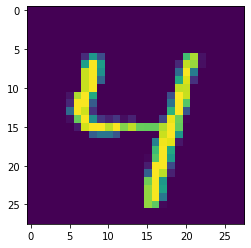

In [19]:
# load a sample image from the test dataset
# to evaluate the model

img = np.asarray(
        Image.open(
            dataset_path + "/testing/4/210.png"
        )
    )
plt.imshow(img)
img = img.reshape((img.shape[0] * img.shape[1]))[:, cp.newaxis]

X_n = img

# to CuPy
X_n = cp.array(X_n) / 255

# predict it
prediction = forward(X_n, (W1, W2, W3), (b1, b2, b3))[-1]
[print(index, p)for index, p in enumerate(list(prediction))]
print('The system predicted: ', list(prediction).index(max(list(prediction))))

In [20]:
# validate

Y_prediction_train = forward(cp.array(dataset['train']['X']),
                            (W1, W2, W3), (b1, b2, b3))[-1]
Y_train = cp.array(dataset['train']['Y'])


Y_prediction_test = forward(cp.array(dataset['test']['X']),
                            (W1, W2, W3), (b1, b2, b3))[-1]
Y_test = cp.array(dataset['test']['Y'])

print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

train accuracy: 90.20738554603417 %
test accuracy: 90.21896439477888 %


In [10]:
# save weights and biases

W1_df = pd.DataFrame(cp.asnumpy(W1))
W2_df = pd.DataFrame(cp.asnumpy(W2))
W3_df = pd.DataFrame(cp.asnumpy(W3))

b1_df = pd.DataFrame(cp.asnumpy(b1))
b2_df = pd.DataFrame(cp.asnumpy(b2))
b3_df = pd.DataFrame(cp.asnumpy(b3))

[df.to_csv('cache/W/' + name, index=False) for df, name in zip(
    (W1_df, W2_df, W3_df),
    ('w1.csv', 'w2.csv', 'w3.csv'))]

[df.to_csv('cache/b/' + name, index=False) for df, name in zip(
    (b1_df, b2_df, b3_df),
    ('b1.csv', 'b2.csv', 'b3.csv'))]

[None, None, None]

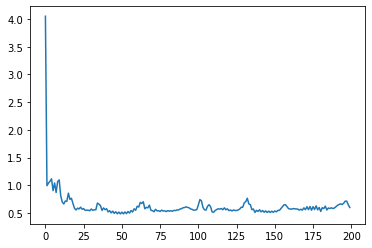

In [13]:
# plot
plt.plot(range(len(costs)), costs)
plt.show()
